# Debug the wave fracture routine in CICE
The error warning _"step_wavefracture struggling to converge"_ appears quite often during simulations. This error is produced when the number of subcycling timesteps exceeds 100, (`nsubt>100`). 

The FSTD is solved using an Euler scheme [Horvat and Tziperman, JGR: Oceans (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012573).

The numerical scheme evolves a matrix representation of the floe size distribution, $f_{jk}$ based on a discretization of floe sizes $r_j$, and thicknesses $h_k$. The value taken by $f_{jk}\Delta r_j \Delta h_k = f_{jk} (r_{j+1} - r_j)(h_{k+1} - h_k)$ is the area fraction that is covered by floes with size between $r_j$ and $r_{j+1}$ and thickness between $h_k$ and  $h_{k+1}$, and the time evolution of $f_{jk}$ is computed according to,

$$ \frac{\mathbf{f}^{j+1} - \mathbf{f}^j}{\Delta t_0} = \mathcal{L}_A(\mathbf{f}^j) + \mathcal{L}_T(\mathbf{f}^j) + \mathcal{L}_M(\mathbf{f}^j) + \mathcal{L}_W(\mathbf{f}^j), $$

where:
- $\Delta t_0 = t_{j+1} - t_j$ is the model time step
- $ \mathcal{L}_A$ represents the tendency of the FSTD due to advection
- $ \mathcal{L}_T$ represents the tendency of the FSTD due to thermodynamics
- $ \mathcal{L}_M$ represents the tendency of the FSTD due to mechanical redistribution
- $ \mathcal{L}_W$ represents the tendency of the FSTD due to wave fracture

In [363]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings
import dask
from dask.distributed import Client
from datetime import timedelta
import glob
import os
from datatree import DataTree, map_over_subtree
import re
import socket
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import matplotlib.colors as mcolors
import calendar

warnings.filterwarnings('ignore')

import sys
sys.path.append("/Users/noahday/GitHub/access-om3-analysis/functions")

from fstd import *

ds = xr.open_dataset("/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/history/iceh.2005-01-01.nc")
floe_rad_c = ds['NFSD'].values
floe_rad_binwidths, floe_rad_l, floe_rad_r = ciceBinWidths(floe_rad_c)

**Appendix A: Time Stepping Scheme of FSTD Model**

Floe categories must be represented by nonnegative areas, and the total ice concentration can never exceed one. Given an FSTD and a set of external forcing fields, these constraints place a strict bound on the model time-step in the forward Euler scheme described by equation 1. However, given the nonlinear relationship between the forcing and the FSTD, a model time-step that ensures these constraints are met is difficult to estimate, and may be smaller than necessary for numerical stability. To address this issue, we designed an adaptive time-stepping procedure which shortens the model time-step as needed. The positive definite constraint is that for all ${j,k}$, 
$$ 0 \leq f_{jk} \Delta A_{jk} \leq 1 \quad \quad \quad (1)$$
where $\Delta A_{jk} = \Delta r_j \Delta h_k$. In order to assure the positivity of the FSD, after computing the tendency in fjk, for all {j, k}, the model time step $\Delta t = t^{j+1} - t^i$ is required to satisfy
$$ \Delta t < \frac{f_{jk}}{\Delta f_{jk}},  \quad \quad \quad (2)$$
where:
- $f_{jk}$ represents the value before the update during the current timestep, 
- $\Delta f_{jk}$ is the updated value.

In order for the solution to be bounded by 1 (satisfying SIC), the model timestep must satisfy 
$$ \Delta t < \frac{1 - f_{jk} \Delta A_{jk}}{\Delta f_{jk} \Delta A_{jk}}.  \quad \quad \quad (3)$$
The updated model time-step $\Delta t$ is then chosen as the maximum value for which all constraints are met and $\Delta t \leq \Delta t_0$, where $\Delta t_0$ is a global time-step specified at the beginning of the simulation. The external forcing fields (wave spectrum, heating) are updated every $\Delta t_0$. The matrix $\mathbf{f}$ is updated using the time step $\Delta t_0$, and the procedure is then repeated using an initial step of $\Delta t_0 - \Delta t$, reducing it as necessary, until the next update of the external forcing fields after a time $\Delta t_0$ elapsed. At that point the time stepping is reinitialized with $\Delta t = \Delta t_0$.

In the code:
- `afsd_init[k]`: $f_{jk} \Delta A_{jk}$
- `d_afsd`: $\Delta f_{jk} \Delta A_{jk}$

In [364]:
#----------------------------------------------------------------

def get_subdt_fsd(afsd_init, d_afsd, puny=1.0e-11, bignum=1.0e20):
    """
    Calculate adaptive subcycle timestep based on floe size evolution.

    Parameters
    ----------
    afsd_init : ndarray (nfsd,)
        Initial floe size distribution.
    d_afsd : ndarray (nfsd,)
        Rate of change of floe size distribution.
    puny : float
        Small numerical threshold.
    bignum : float
        A large number representing the default max timestep.

    Returns
    -------
    subdt : float
        Minimum stable subcycle timestep (s).
    """
    nfsd = len(afsd_init)
    check_dt = np.full(nfsd, bignum)

    for k in range(nfsd):
        if d_afsd[k] > puny:
            # If we want to add ice, check how close we are to the upper limit
            # Eq. (2)
            check_dt[k] = (1.0 - afsd_init[k]) / d_afsd[k]
        elif d_afsd[k] < -puny:
            # If we want to remove ice, check how far from the lower limit
            # Eq. (1)
            check_dt[k] = afsd_init[k] / abs(d_afsd[k])

    subdt = np.min(check_dt)
    return subdt

#----------------------------------------------------------------

### Cleanup FSD routines


If $\sum_j f_{jk} \Delta A_{jk} > 0$ then:
$$ f_{jk} \Delta A_{jk} = \frac{f_{jk} \Delta A_{jk}}{\sum_j f_{jk} \Delta A_{jk}}$$
but if some entries in $f_{jk} \Delta A_{jk}$ are negative, 

In [365]:

def icepack_cleanup_fsd(afsdn, tr_fsd=True, puny=1.0e-11, c0=0.0):
    """
    Clean up small/negative values and renormalize the FSD array.

    Parameters
    ----------
    afsdn : ndarray (nfsd, ncat)
        Floe size distribution tracer array (in-place modified).
    tr_fsd : bool
        Whether to apply FSD cleanup.
    puny : float
        Numerical threshold for filtering small values.
    c0 : float
        Replacement value for small/invalid values.
    """
    if not tr_fsd:
        return

    ncat = afsdn.shape[1]
    for n in range(ncat):
        icepack_cleanup_fsdn(afsdn[:, n])


#----------------------------------------------------------------
def icepack_cleanup_fsdn(afsd):
    """
    Clean up a single floe size distribution vector.

    Parameters
    ----------
    afsd : ndarray (nfsd,)
        FSD for a single thickness category (in-place modified).
    puny : float
        Threshold below which values are zeroed.
    c0 : float
        Replacement for invalid small values.
    """
    afsd[afsd < puny] = c0

    total = np.sum(afsd)
    if total > 0:
        afsd /= total # Normalise it
#----------------------------------------------------------------

In [366]:
### Functions from icepack

def icepack_step_wavefracture(
    wave_spec_type,
    dt,
    nfreq,
    aice,
    vice,
    aicen,
    wave_spectrum,
    wavefreq,
    dwavefreq,
    trcrn,
    d_afsd_wave,
    get_dafsd_wave,
    get_subdt_fsd,
    wave_frac,
    icepack_cleanup_fsd,
    nfsd,
    ncat,
    nt_fsd,
):
    subname = 'icepack_step_wavefracture'

    # Initialize
    convergence_test = True
    d_afsd_wave[:] = c0
    d_afsdn_wave = np.zeros((nfsd, ncat))
    fracture_hist = np.zeros(nfsd)

    # If all ice is not in the first floe size category
    if not np.all(trcrn[nt_fsd, :] >= c1 - puny):

        local_sig_ht = c4 * np.sqrt(np.sum(wave_spectrum * dwavefreq))

        if (aice > p01) and (local_sig_ht > 0.1):
            hbar = vice / aice

            # Calculate fracture histogram
            fracture_hist = wave_frac(nfreq, wave_spec_type, wavefreq, dwavefreq, hbar, wave_spectrum)

            if np.max(fracture_hist) > puny:
                icepack_cleanup_fsd(trcrn[nt_fsd:nt_fsd + nfsd, :])

                for n in range(ncat):
                    afsd_init = trcrn[nt_fsd:nt_fsd + nfsd, n].copy()

                    if (aicen[n] > puny and
                        np.sum(afsd_init) > puny and
                        afsd_init[0] < c1):

                        afsd_tmp = afsd_init.copy()

                        frac = np.zeros((nfsd, nfsd))
                        for k in range(1, nfsd):
                            frac[k, :k] = fracture_hist[:k]

                        for k in range(nfsd):
                            total = np.sum(frac[k, :])
                            if total > c0:
                                frac[k, :] /= total

                        elapsed_t = c0
                        cons_error = c0
                        nsubt = 0

                        while elapsed_t < dt:
                            nsubt += 1
                            if afsd_tmp[0] >= c1 - puny:
                                break

                            d_afsd_tmp = get_dafsd_wave(afsd_tmp, fracture_hist, frac)

                            if nsubt > 100:
                                print(f"{subname}: warning: step_wavefracture struggling to converge")
                                convergence_test = False

                            subdt = get_subdt_fsd(afsd_tmp, d_afsd_tmp)
                            subdt = min(subdt, dt - elapsed_t)

                            afsd_tmp += subdt * d_afsd_tmp

                            if np.min(afsd_tmp) < -puny:
                                print(f"{subname}: warning: negative value in FSD")
                            if np.max(afsd_tmp) > c1 + puny:
                                print(f"{subname}: warning: FSD > 1")

                            elapsed_t += subdt

                        # Area conservation
                        cons_error = np.sum(afsd_tmp) - c1

                        if cons_error < c0:
                            afsd_tmp[0] -= cons_error
                        else:
                            for k in reversed(range(nfsd)):
                                if afsd_tmp[k] > cons_error:
                                    afsd_tmp[k] -= cons_error
                                    break

                        trcrn[nt_fsd:nt_fsd + nfsd, n] = afsd_tmp / np.sum(afsd_tmp)
                        icepack_cleanup_fsd(trcrn[nt_fsd:nt_fsd + nfsd, :])

                        d_afsdn_wave[:, n] = afsd_tmp - afsd_init
                        d_afsd_wave[:] += aicen[n] * d_afsdn_wave[:, n]

    return d_afsd_wave, d_afsdn_wave, convergence_test

#----------------------------------------------------------------

def wave_frac(nfreq, wave_spec_type, wavefreq, dwavefreq, hbar, spec_efreq):

    # Spatial domain
    X = np.arange(1, nx + 1) * dx

    # Wavelengths from dispersion relation
    lambda_ = gravit / (c2 * pi * wavefreq**2)

    # Spectral coefficients
    spec_coeff = np.sqrt(c2 * spec_efreq * dwavefreq)

    # Initialize
    frac_local = np.zeros(nfsd)
    prev_frac_local = np.zeros(nfsd)
    frachistogram = np.zeros(nfsd)
    fraclengths = np.zeros(nx)
    eta = np.zeros(nx)
    fracerror = 1.0e20
    errortol = 6.5e-4
    iter = 0

    loop_max_iter = max_no_iter if wave_spec_type.strip() == 'random' else 1

    while iter < loop_max_iter and fracerror > errortol:
        iter += 1

        # Random or constant phase
        if wave_spec_type.strip() == 'random':
            rand_array = np.random.rand(nfreq)
        else:
            rand_array = np.full(nfreq, 0.5)

        phi = c2 * pi * rand_array

        # Construct eta field
        for j in range(nx):
            eta[j] = np.sum(spec_coeff * np.cos((2 * pi * X[j]) / lambda_ + phi))

        # Compute fracture lengths
        fraclengths[:] = c0
        if np.sum(np.abs(eta)) > puny and hbar > puny:
            fraclengths = get_fraclengths(X, eta, hbar, dx, nx, straincrit, c0)

        fraclengths /= c2  # Convert diameter to radius

        if np.all(fraclengths < floe_rad_l[0]):
            frac_local[:] = c0
        else:
            for fl in fraclengths:
                if fl > floe_rad_l[0]:
                    for k in range(nfsd - 1):
                        if floe_rad_l[k] <= fl < floe_rad_l[k + 1]:
                            frachistogram[k] += 1
                            break
                    else:
                        if fl > floe_rad_l[-1]:
                            frachistogram[-1] += 1

            frac_local = floe_rad_c * frachistogram

            if np.sum(frac_local) != c0:
                frac_local /= np.sum(frac_local)

        # Convergence check
        if wave_spec_type.strip() == 'random':
            fracerror = np.sum(np.abs(frac_local - prev_frac_local)) / nfsd
            prev_frac_local = frac_local.copy()

    return frac_local

#----------------------------------------------------------------

def get_fraclengths(X, eta, hbar, dx, nx, straincrit, c0=0.0):
    spcing = int(round(10.0 / dx))
    is_max = np.full(nx, False)
    is_min = np.full(nx, False)
    is_extremum = np.full(nx, False)
    is_triplet = np.full(nx, False)
    strain = np.zeros(nx)
    fraclengths = np.zeros(nx)

    # Identify extrema
    for j in range(nx):
        first = max(0, j - spcing)
        last = min(nx, j + spcing + 1)
        window = eta[first:last]
        if j - first == np.argmax(window):
            is_max[j] = True
        if j - first == np.argmin(window):
            is_min[j] = True
        if is_max[j] or is_min[j]:
            is_extremum[j] = True

    # Identify triplets and compute strain
    for j in range(1, nx - 1):
        if not is_extremum[j]:
            continue

        j_neg = next((k for k in range(j - 1, -1, -1) if is_extremum[k]), None)
        j_pos = next((k for k in range(j + 1, nx) if is_extremum[k]), None)

        if j_neg is not None and j_pos is not None:
            if ((is_max[j_neg] and is_min[j] and is_max[j_pos]) or
                (is_min[j_neg] and is_max[j] and is_min[j_pos])):
                is_triplet[j] = True

                delta = X[j] - X[j_neg]
                delta_pos = X[j_pos] - X[j]
                denom = delta * delta_pos * (delta + delta_pos)

                if denom != 0:
                    strain[j] = abs(
                        hbar * (
                            eta[j_neg] * delta_pos -
                            eta[j] * (delta_pos + delta) +
                            eta[j_pos] * delta
                        ) / denom
                    )

    # Extract fracture distances
    strain_exceeds = strain > straincrit
    n_above = np.count_nonzero(strain_exceeds)

    if n_above > 0:
        fracture_points = X[strain_exceeds]
        for j in range(len(fracture_points) - 1):
            fraclengths[j] = fracture_points[j + 1] - fracture_points[j]

    return fraclengths

#----------------------------------------------------------------

def get_dafsd_wave(afsd_init, fracture_hist, frac, puny=1.0e-11, c0=0.0):
    """
    Calculate change in FSD due to wave fracture.

    Parameters
    ----------
    afsd_init : ndarray (nfsd,)
        Initial floe size distribution.
    fracture_hist : ndarray (nfsd,)
        Fracture histogram (assumed normalized).
    frac : ndarray (nfsd, nfsd)
        Redistribution matrix.
    puny : float
        Small number for numerical threshold.
    c0 : float
        Constant for zero.

    Returns
    -------
    d_afsd : ndarray (nfsd,)
        Change in floe size distribution due to wave fracture.
    """
    nfsd = len(afsd_init)

    omega = np.array([
        afsd_init[k] * np.sum(fracture_hist[:k])
        for k in range(nfsd)
    ])

    loss = omega.copy()
    gain = np.sum(omega[:, np.newaxis] * frac, axis=0)

    d_afsd = gain - loss

    if np.sum(d_afsd) > puny:
        print("(get_dafsd_wave): warning: area not conserved, waves")

    d_afsd[np.abs(d_afsd) < puny] = c0

    return d_afsd

#----------------------------------------------------------------

def bretschneider_spectrum(f, Hs, Tp):
    """
    Returns wave spectrum E(f) for given Hs and Tp.
    """
    fp = 1.0 / Tp
    alpha = 1.25
    g = 9.81
    E = (5 / 16) * Hs**2 * fp**4 * f**-5 * np.exp(-1.25 * (fp / f)**4)
    return E

#----------------------------------------------------------------

## Test case for a single spectrum

In [367]:
# Constants
nfsd = len(ds['NFSD'])   # Number of floe size categories
ncat = 5   # Number of ice thickness categories
nt_fsd = 0  # Index where FSD tracers begin

# Inputs
dt = 3600.0  # 1 hour timestep [s]
nfreq = 31   # Number of wave frequencies

# Example wave spectrum
nw = 31  # Number of wave frequencies
F_MIN = 0.042  # Minimum frequency [Hz]
F_MAX = 1/2.5   # Maximum frequency [Hz]
om1 = 2 * np.pi * F_MIN  # Minimum angular frequency (rad/s)
om2 = 2 * np.pi * F_MAX  # Maximum angular frequency (rad/s)
om_0 = (om2 - om1) / (nw - 1)  # Frequency step (rad/s)

# Calculate wave numbers and wavelengths
omega = np.linspace(om1, om2, nw)  # Angular frequencies (rad/s)

wavefreq = omega/(2 * np.pi);
dwavefreq = wavefreq - np.concatenate(([0], wavefreq[0:-1]), axis=0)
dwavew = 2 * np.pi * dwavefreq


Hs = 4 # Significant wave height [m]
Tp = 10  # Peak period [s]
fp = 1 / Tp  # Peak frequency [Hz]

# Bretschneider wave spectrum
wave_spectrum = bretschneider_spectrum(wavefreq, Hs, Tp)
print('Hs            = ', Hs, 'm')
print('Integrated Hs = ', np.round(4*np.sqrt(np.dot(dwavefreq, wave_spectrum)), 2), 'm')

# Ice parameters
aice = 0.8   # Total ice concentration
vice = 0.6   # Total ice volume
aicen = np.array([0.3, 0.3, 0.2, 0.1, 0.1])  # Ice area by category
# Ice tracer array: rows = tracers, cols = categories
trcrn = np.zeros((nt_fsd + nfsd, ncat))
# Define a decaying distribution (e.g. exponential) and normalize each column to sum to 1
base = np.array([0.7, 0.15, 0.05, 0.03, 0.02, 0.015, 0.01, 0.007, 0.005, 0.003, 0.002, 0.001])

# Normalize so each column sums to 1
trcrn_fsd = np.tile(base[:, np.newaxis], (1, ncat))
trcrn_fsd /= np.sum(trcrn_fsd, axis=0)

# Initialize full tracer array (assuming nt_fsd+nfsd rows, ncat columns)
trcrn = np.zeros((nt_fsd + nfsd, ncat))
trcrn[nt_fsd:nt_fsd + nfsd, :] = trcrn_fsd
# Placeholder for output
d_afsd_wave = np.zeros(nfsd)

Hs            =  4 m
Integrated Hs =  3.99 m


In [368]:
# Wave-induced ice breakup parameters
swh_minval = 0.01   # minimum value of wave height (m)
straincrit = 3.e-5  # critical strain
D          = 1.e4   # domain size
dx         = 1.0    # domain spacing
threshold  = 10.0   # peak-finding threshold -
                    # points are defined to be extrema if they
                    # are a local max or min over a distance
                    # of 10m on both sides, based on the
                    # observations of Toyota et al. (2011) who
                    # find this to be the order of the smallest
                    # floe size affected by wave fracture
nx = 10000          # number of points in domain
max_no_iter = 100   # max no of iterations to compute wave fracture

# Constants
gravit = 9.81
pi = np.pi
p1 = 0.01
p01 = 0.01
c0 = 0.0
c1 = 1.0
c2 = 2.0
c4 = 4.0
puny = 1.0e-11

d_afsd_wave_out, d_afsdn_wave_out, convergence_test = icepack_step_wavefracture(
    wave_spec_type="random",
    dt=dt,
    nfreq=nfreq,
    aice=aice,
    vice=vice,
    aicen=aicen,
    wave_spectrum=wave_spectrum,
    wavefreq=wavefreq,
    dwavefreq=dwavefreq,
    trcrn=trcrn,
    d_afsd_wave=d_afsd_wave,
    get_dafsd_wave=get_dafsd_wave,
    get_subdt_fsd=get_subdt_fsd,
    wave_frac=wave_frac,
    icepack_cleanup_fsd=icepack_cleanup_fsd,
    nfsd=nfsd,
    ncat=ncat,
    nt_fsd=nt_fsd
)
convergence_test

True

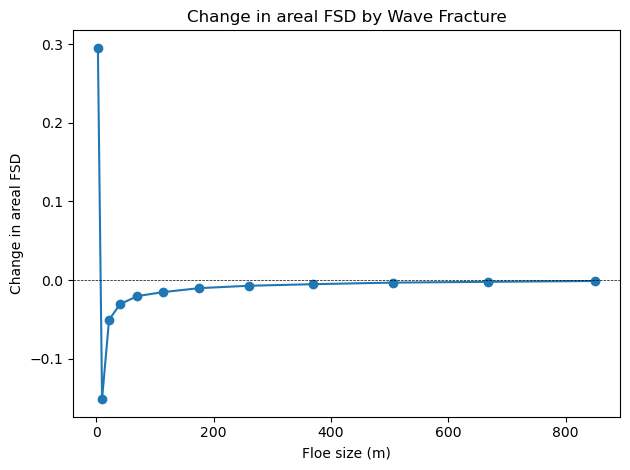

In [369]:
import seaborn as sns

plt.scatter(floe_rad_c, d_afsd_wave_out)
plt.plot(floe_rad_c, d_afsd_wave_out)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.xlabel('Floe size (m)')
plt.ylabel('Change in areal FSD')
plt.title('Change in areal FSD by Wave Fracture')
plt.tight_layout()
plt.show()

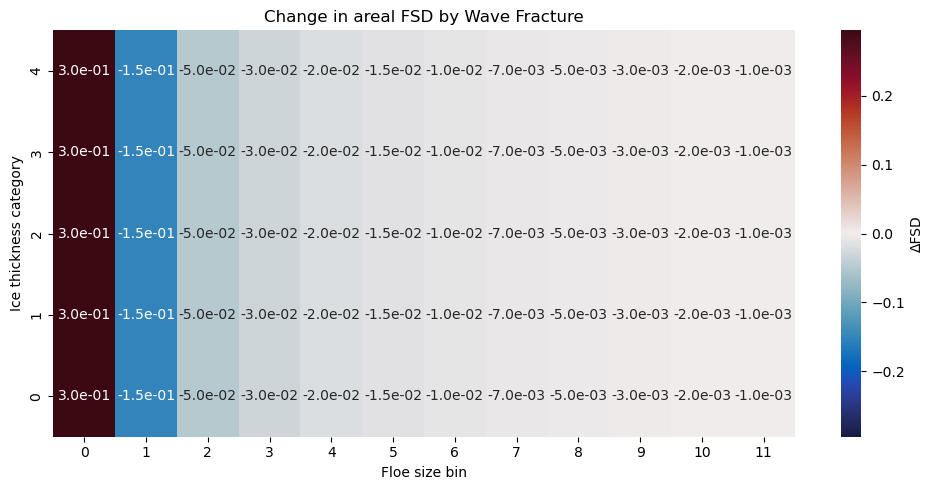

In [370]:
absmax = np.max(np.abs(d_afsdn_wave_out))

plt.figure(figsize=(10, 5))
sns.heatmap(
    d_afsdn_wave_out.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'ΔFSD'}
)
plt.gca().invert_yaxis()
plt.ylabel('Ice thickness category')
plt.xlabel('Floe size bin')
plt.title('Change in areal FSD by Wave Fracture')
plt.tight_layout()
plt.show()

Strain is actually independent of the ITD since the cell average ice thickness, $\bar{h}_{ice}$, is used and calculated as $$ \bar{h}_{ice} = \frac{v_{ice}}{a_{ice}} $$
using the cell's total ice volume and areal concentration.

## Testing the breakup for a range of wave and ice parameters

GOAL: Find the cases when we get non-convergence


### First we look at varying wave parameters

In [371]:
Hs_vals = np.linspace(0.1, 10.0, 5)   # Significant wave height [m]
Tp_vals = np.linspace(1.0, 23.0, 5)  # Peak period [s]

results = {}

for Hs in Hs_vals:
    for Tp in Tp_vals:
        # Generate spectrum
        wave_spectrum = bretschneider_spectrum(wavefreq, Hs, Tp)

        # Call wave fracture routine (example)
        d_afsd_wave_out, d_afsdn_wave_out, convergence_test = icepack_step_wavefracture(
            wave_spec_type="random",
            dt=dt,
            nfreq=nfreq,
            aice=aice,
            vice=vice,
            aicen=aicen,
            wave_spectrum=wave_spectrum,
            wavefreq=wavefreq,
            dwavefreq=dwavefreq,
            trcrn=trcrn,
            d_afsd_wave=d_afsd_wave,
            get_dafsd_wave=get_dafsd_wave,
            get_subdt_fsd=get_subdt_fsd,
            wave_frac=wave_frac,
            icepack_cleanup_fsd=icepack_cleanup_fsd,
            nfsd=nfsd,
            ncat=ncat,
            nt_fsd=nt_fsd
        )
        results[(Hs, Tp)] = {
            'd_afsd_wave': d_afsd_wave_out,
            'd_afsdn_wave': d_afsdn_wave_out,
            'convergence_test': convergence_test
        }

In [372]:
for (Hs, Tp), result in results.items():
    d_afsd = result['d_afsd_wave']
    d_afsdn = result['d_afsdn_wave']
    if not result['convergence_test']:
        print(f"Hs = {Hs:.2f} m, Tp = {Tp:.2f} s")

### Now we vary ice parameters

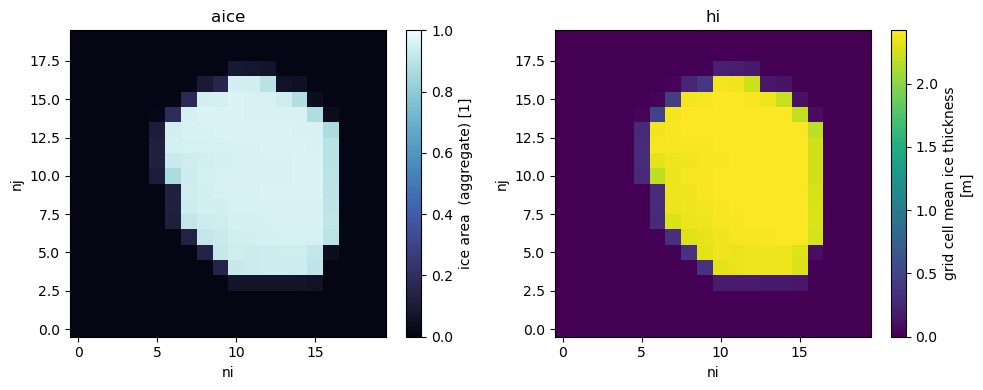

In [373]:
ds_tmp = ds.copy().isel(time=0).isel(nj=slice(5, 25), ni=slice(100, 120))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ds_tmp['aice'].plot(ax=axes[0], cmap=cmo.ice, vmin=0, vmax=1)
axes[0].set_title('aice')

ds_tmp['hi'].plot(ax=axes[1])
axes[1].set_title('hi')

plt.tight_layout()
plt.show()

In [374]:
i, j = 10, 10
print(ds_tmp['aice'][i,j].values)
ds_tmp = ds_tmp.isel(ni=i, nj=j)

0.9596482515335083


In [375]:
NCAT = ds_tmp['NCAT'].values
# NCAT = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])


# Open the file
# ds_restart = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc')
# ds_restart
puny = 10**(-12)
thicknesses = ds_tmp['vicen']/ds_tmp['aicen']
temp_aicen = [1.0, puny, puny, puny, puny]*(0.05/thicknesses)
temp_vicen = thicknesses*temp_aicen
temp_vicen.sum()

<xarray.DataArray ()>
array(0.05)
Coordinates:
    time     datetime64[ns] 2005-01-02
    TLON     float64 190.5
    TLAT     float64 -73.8
    ULON     float64 -169.0
    ULAT     float64 -73.63

In [376]:
# Verify that the thicknesses do not escape their bins

def constrain_thickneses(vicen_in, aicen_in):
    # NCAT taken from CICE input file
    thicknesses = vicen_in/aicen_in # Bitz
    upper_bounds = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])
    lower_bounds = np.insert(upper_bounds[0:-1], 0, 0)
    thickness_greater = (thicknesses > upper_bounds).all()
    thickness_not_smaller = (thicknesses < lower_bounds).all()

    if (thickness_greater).any():
        print('ERROR: Thickness exceeds upper bounds')
        print(thicknesses)
        print(upper_bounds)
    elif (thickness_not_smaller).any():
        print('ERROR: Thickness subceeds lower bounds')
        print(thicknesses)
        print(lower_bounds)
    else: 
        print('PASSED tests')
    
temp_thickness = np.insert(NCAT[0:-1], 0, 0) + 0.05
PUNY = 10**(-12)
temp_aicen = np.array([1.0 - 4*PUNY, PUNY, PUNY, PUNY, PUNY])
temp_vicen = temp_thickness*temp_aicen
constrain_thickneses(temp_vicen, temp_aicen)
print('Initial ITD categories are:',temp_vicen/temp_aicen)
print('Mean ice thickness is:', np.round(temp_vicen.sum(), 3), 'm')

PASSED tests
Initial ITD categories are: [0.05       0.69450724 1.44143343 2.52017927 4.61728811]
Mean ice thickness is: 0.05 m


In [377]:
from scipy.stats import norm
from scipy.optimize import minimize

def gaussian_aicen(thickness_bins, mu, sigma):
    # Use the bin centers as the x-values
    probs = norm.pdf(thickness_bins, loc=mu, scale=sigma)
    return probs / np.sum(probs)  # Normalize to sum to 1

def error_func(params, thickness_bins, desired_thickness):
    mu, sigma = params
    if sigma <= 0:
        return np.inf  # penalize non-physical values
    aicen = gaussian_aicen(thickness_bins, mu, sigma)
    mean_thickness = np.sum(aicen * thickness_bins)
    return (mean_thickness - desired_thickness) ** 2

def get_gaussian_aicen(thickness_bins, desired_thickness, mu_guess=1.0, sigma_guess=1.0):
    res = minimize(
        error_func,
        x0=[mu_guess, sigma_guess],
        args=(thickness_bins, desired_thickness),
        bounds=[(min(thickness_bins), max(thickness_bins)), (1e-3, 10)],
        method='L-BFGS-B'
    )
    if res.success:
        mu_opt, sigma_opt = res.x
        aicen = gaussian_aicen(thickness_bins, mu_opt, sigma_opt)
        return aicen, mu_opt, sigma_opt
    else:
        raise RuntimeError("Gaussian fitting failed: " + res.message)

# Inputs
thickness_bins = np.insert(np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00]), 0, 0) + 0.05
desired_initial_thickness = 2.0

# Fit Gaussian
aicen_fit, mu_fit, sigma_fit = get_gaussian_aicen(thickness_bins, desired_initial_thickness)

# Compute resulting volume
vicen_fit = aicen_fit * thickness_bins

# Report
print("Fitted μ (mean of Gaussian):", np.round(mu_fit, 3))
print("Fitted σ (std dev of Gaussian):", np.round(sigma_fit, 3))
print("Area fractions:", np.round(aicen_fit, 4))
print("Initial ITD categories (h_i):", np.round(thickness_bins, 3))
print("Mean ice thickness:", np.round(np.sum(vicen_fit), 4), "m")

Fitted μ (mean of Gaussian): 2.548
Fitted σ (std dev of Gaussian): 1.523
Area fractions: [0.0898 0.1643 0.2646 0.3444 0.1369]
Initial ITD categories (h_i): [0.05  0.695 1.441 2.52  4.617]
Mean ice thickness: 2.0 m


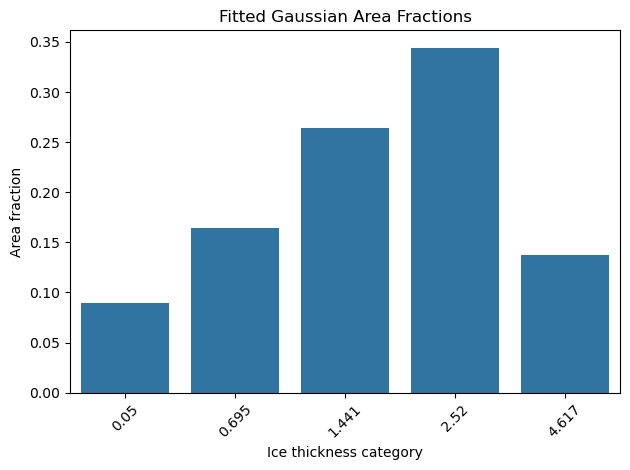

In [378]:
sns.barplot(aicen_fit)
plt.xlabel('Ice thickness category')
plt.ylabel('Area fraction')
plt.title('Fitted Gaussian Area Fractions')
plt.xticks(ticks=np.arange(len(thickness_bins)), labels=np.round(thickness_bins, 3), rotation=45)
plt.tight_layout()
plt.show()

In [379]:
# Ice parameters
aice = aicen_fit.sum()  # Total ice concentration
vice = vicen_fit.sum()   # Total ice volume
aicen = aicen_fit #np.array([0.3, 0.3, 0.2, 0.1, 0.1])  # Ice area by category
vicen = vicen_fit
# Ice tracer array: rows = tracers, cols = categories
trcrn = np.zeros((nt_fsd + nfsd, ncat))
# Define a decaying distribution (e.g. exponential) and normalize each column to sum to 1
base = np.array([0.7, 0.15, 0.05, 0.03, 0.02, 0.015, 0.01, 0.007, 0.005, 0.003, 0.002, 0.001])
base_tile = np.tile(base[:, np.newaxis], (1, ncat))  # shape: (nfsd, ncat)

# Scale each column so sum equals aicen per category
# base sums to 1, so multiply by aicen
base_scaled = base_tile * aicen[np.newaxis, :]  # assuming aicen is an xarray DataArray, convert to numpy array

# Assign this scaled base to tracer array rows corresponding to nfsd
trcrn[nt_fsd:nt_fsd + nfsd, :] = base_scaled
d_afsd_wave = np.zeros(nfsd)

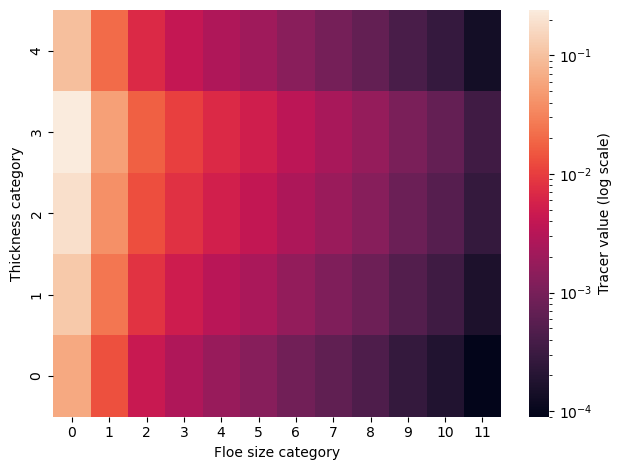

In [380]:
from matplotlib.colors import LogNorm
sns.heatmap(
    trcrn.T,
    norm=LogNorm(vmin=np.maximum(trcrn[trcrn > 0].min(), 1e-5), vmax=trcrn.max()),
    cbar_kws={'label': 'Tracer value (log scale)'}
)
plt.gca().invert_yaxis()
plt.xlabel('Floe size category')
plt.ylabel('Thickness category')
plt.tight_layout()
plt.show()

In [381]:
wave_spectrum = bretschneider_spectrum(wavefreq, 4, 10)

ai_vals = np.linspace(0.1, 1.0, 10)   # ice concentration [0-1]
hi_vals = np.linspace(0.1, 4.0, 10)   # ice thickness [m]

results = {}

for desired_aice in ai_vals:
    for desired_thickness in hi_vals:

        aicen_fit, mu_fit, sigma_fit = get_gaussian_aicen(thickness_bins, desired_thickness)
        # Compute resulting volume
        aicen_fit = aicen_fit * desired_aice
        vicen_fit = aicen_fit * thickness_bins

        aice = aicen_fit.sum()  # Total ice concentration
        vice = vicen_fit.sum()   # Total ice volume
        aicen = aicen_fit # Ice area by category
        vicen = vicen_fit

        base_scaled = base_tile * aicen[np.newaxis, :]  # assuming aicen is an xarray DataArray, convert to numpy array

        # Assign this scaled base to tracer array rows corresponding to nfsd
        trcrn[nt_fsd:nt_fsd + nfsd, :] = base_scaled
        d_afsd_wave = np.zeros(nfsd)
        
        # Call wave fracture routine (example)
        d_afsd_wave_out, d_afsdn_wave_out, convergence_test = icepack_step_wavefracture(
            wave_spec_type="random",
            dt=dt,
            nfreq=nfreq,
            aice=aice,
            vice=vice,
            aicen=aicen,
            wave_spectrum=wave_spectrum,
            wavefreq=wavefreq,
            dwavefreq=dwavefreq,
            trcrn=trcrn,
            d_afsd_wave=d_afsd_wave,
            get_dafsd_wave=get_dafsd_wave,
            get_subdt_fsd=get_subdt_fsd,
            wave_frac=wave_frac,
            icepack_cleanup_fsd=icepack_cleanup_fsd,
            nfsd=nfsd,
            ncat=ncat,
            nt_fsd=nt_fsd
        )

        if not convergence_test:
            print(f"Convergence failed for aice={desired_aice}, thickness={desired_thickness}")
        
        results[(desired_aice, desired_thickness)] = {
            'd_afsd_wave': d_afsd_wave_out,
            'd_afsdn_wave': d_afsdn_wave_out,
            'convergence_test': convergence_test
        }

KeyboardInterrupt: 

In [ ]:
for hi, result in results.items():
    d_afsd = result['d_afsd_wave']
    d_afsdn = result['d_afsdn_wave']
    if not result['convergence_test']:
        print(f"hi = {hi:.2f} m")

In [ ]:
convergences = [res['convergence_test'] for res in results.values()]
print(convergences)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


<Axes: >

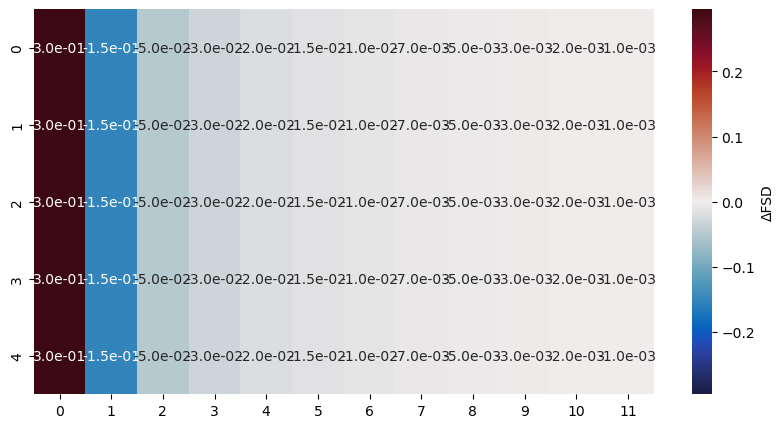

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    d_afsdn_wave_out.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'ΔFSD'}
)

## Vary mean FSD

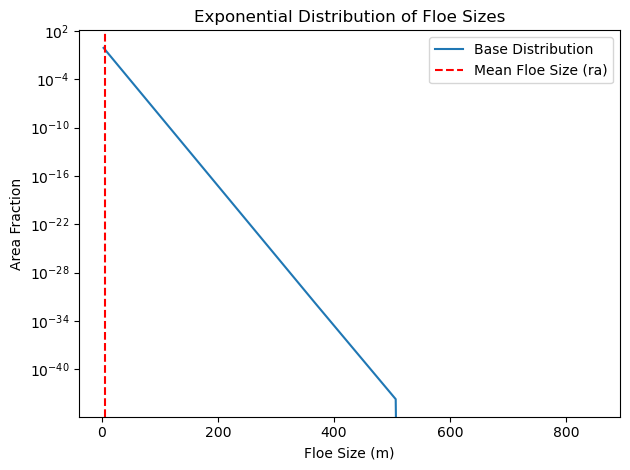

In [ ]:
def get_fsd_pdf(ra):
    # Compute exponential distribution
    lam = 1.0 / ra
    base = lam * np.exp(-lam * floe_rad_c)

    # Normalize to sum to 1 (if required, e.g., for probabilities or fractional area)
    base /= base.sum()

    # Tile to shape (nbins, ncat)
    base_tile = np.tile(base[:, np.newaxis], (1, ncat))

    afsd_pdf = base
    afsdn_pdf = base_tile

    return afsd_pdf, afsdn_pdf

ra = 5.0      # mean of the exponential distribution


afsd_pdf, afsdn_pdf = get_fsd_pdf(ra)

plt.plot(floe_rad_c, afsd_pdf, label='Base Distribution')
plt.yscale('log')
plt.xlabel('Floe Size (m)')
plt.ylabel('Area Fraction')
plt.title('Exponential Distribution of Floe Sizes')
plt.axvline(ra, color='red', linestyle='--', label='Mean Floe Size (ra)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
wave_spectrum = bretschneider_spectrum(wavefreq, 4, 10)

ra_vals = np.linspace(0.1, 1, 10)   # representative floe radius [m]

results = {}
desired_aice = 0.73
desired_thickness = 0.43520903 # Example desired thickness
aicen_fit, mu_fit, sigma_fit = get_gaussian_aicen(thickness_bins, desired_thickness)

# Compute resulting volume
aicen_fit = aicen_fit * desired_aice
vicen_fit = aicen_fit * thickness_bins

aice = aicen_fit.sum()  # Total ice concentration
vice = vicen_fit.sum()   # Total ice volume
aicen = aicen_fit # Ice area by category
vicen = vicen_fit

for desired_ra in ra_vals:

    afsd_pdf, afsdn_pdf = get_fsd_pdf(desired_ra)
    afsdn_scaled = afsdn_pdf * aicen[np.newaxis, :]  # assuming aicen is an xarray DataArray, convert to numpy array

    # Assign this scaled base to tracer array rows corresponding to nfsd
    trcrn[nt_fsd:nt_fsd + nfsd, :] = afsdn_scaled
    d_afsd_wave = np.zeros(nfsd)
    
    # Call wave fracture routine (example)
    d_afsd_wave_out, d_afsdn_wave_out, convergence_test = icepack_step_wavefracture(
        wave_spec_type="random",
        dt=dt,
        nfreq=nfreq,
        aice=aice,
        vice=vice,
        aicen=aicen,
        wave_spectrum=wave_spectrum,
        wavefreq=wavefreq,
        dwavefreq=dwavefreq,
        trcrn=trcrn,
        d_afsd_wave=d_afsd_wave,
        get_dafsd_wave=get_dafsd_wave,
        get_subdt_fsd=get_subdt_fsd,
        wave_frac=wave_frac,
        icepack_cleanup_fsd=icepack_cleanup_fsd,
        nfsd=nfsd,
        ncat=ncat,
        nt_fsd=nt_fsd
    )

    if not convergence_test:
        print(f"Convergence failed for r_a={desired_ra}")
    
    results[(desired_ra)] = {
        # 'd_afsd_wave': d_afsd_wave_out,
        # 'd_afsdn_wave': d_afsdn_wave_out,
        'convergence_test': convergence_test
    }

In [ ]:
results

{0.1: {'convergence_test': True},
 0.2: {'convergence_test': True},
 0.30000000000000004: {'convergence_test': True},
 0.4: {'convergence_test': True},
 0.5: {'convergence_test': True},
 0.6: {'convergence_test': True},
 0.7000000000000001: {'convergence_test': True},
 0.8: {'convergence_test': True},
 0.9: {'convergence_test': True},
 1.0: {'convergence_test': True}}

<Axes: >

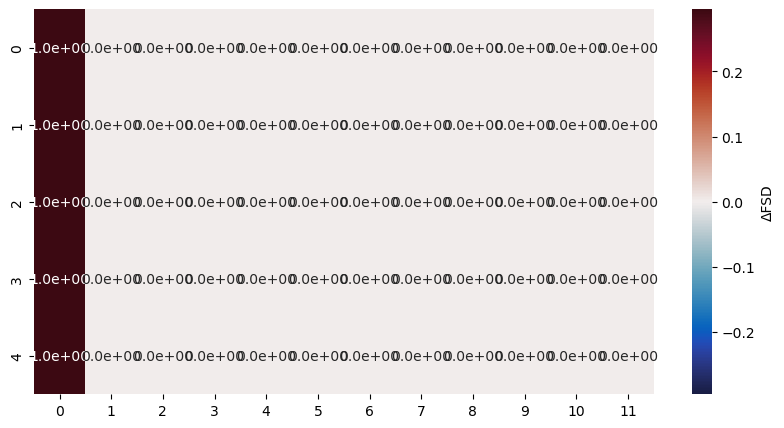

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    trcrn.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'ΔFSD'}
)

## Using the CICE runlog to debug

In [ ]:
# f = open('/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250716-123317', 'r')
# lines = f.read()
# answer = lines.find('struggling to converge')

In [386]:
from collections import deque
# filename = '/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250716-140421'
# filename = '/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250717-131011'
filename = '/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250717-134048'

n_before = 10
n_after = 2

counter = 0

with open(filename, 'r') as inF:
    prev_lines = deque(maxlen=n_before)  # stores previous n lines
    after_counter = 0  # how many lines after match to print

    for line in inF:
        if after_counter > 0:
            print(line.strip())
            after_counter -= 1

        if 'struggling' in line:
            print("\n--- Match Found ---")
            for prev in prev_lines:
                print(prev.strip())
            print(line.strip())
            after_counter = n_after
            counter += 1
            if counter >= 0:  # stop after 5 matches
                print("\n--- Stopping after 5 matches ---")
                break

        prev_lines.append(line)


In [ ]:
def is_numeric_line(line, threshold=0.5):
    """Return True if a line contains mostly numeric tokens (supports floats, scientific)."""
    tokens = line.strip().split()
    if not tokens:
        return False
    numeric_tokens = sum(1 for t in tokens if re.match(r'^-?[\d\.Ee\+\-]+$', t))
    return (numeric_tokens / len(tokens)) >= threshold

# Combine all relevant lines
all_lines = list(prev_lines) + [match_line] + after_lines

# Extract numeric lines
arrays = []
for l in all_lines:
    if is_numeric_line(l):
        try:
            arr = np.fromstring(l, sep=' ')
            arrays.append(arr)
        except Exception as e:
            print(f"Error parsing line: {l}")
            print(e)

# Print arrays
for i, arr in enumerate(arrays):
    print(f"\nArray {i}: shape {arr.shape}")
    print(arr)


Array 0: shape (1,)
[-1.]

Array 1: shape (1,)
[-1.]

Array 2: shape (1,)
[-1.]

Array 3: shape (1,)
[-1.]

Array 4: shape (1,)
[-1.]

Array 5: shape (1,)
[-1.]


In [ ]:
# Dictionary to store results
data_arrays = {}

for line in all_lines:
    parts = line.strip().split()
    
    # Skip if too short or not a data line
    if len(parts) < 3:
        continue
    
    # Check if first part is something like (step_dyn_wave)
    if parts[0].startswith('(') and ')' in parts[0]:
        var_name = parts[1]
        try:
            values = np.array([float(x) for x in parts[2:]])
            data_arrays[var_name] = values
        except ValueError:
            print(f"Could not convert line for {var_name}")
    else:
        continue  # skip lines like the warning

# ✅ Output
for name, arr in data_arrays.items():
    print(f"\n{name}: shape {arr.shape}")
    print(arr)

Could not convert line for wave_spec_type:
Could not convert line for i,
Could not convert line for step_wavefracture

aice: shape (1,)
[0.73007636]

vice: shape (1,)
[1.67753036]

aicen: shape (5,)
[0.12213266 0.1105204  0.19515232 0.23595089 0.06632009]

wave_spectrum: shape (31,)
[8.64730558e-15 1.93354113e-04 1.59828105e-01 1.03624106e+00
 1.16235773e+00 5.95665082e-01 1.97200181e-01 4.79577538e-02
 8.93229865e-03 1.27798862e-03 1.38201085e-04 1.09963381e-05
 6.22526087e-07 2.41328652e-08 6.14242638e-10 9.81069808e-12
 9.37041348e-14 5.08603498e-16 1.48683917e-18 2.21287873e-21
 1.58074188e-24 5.09642142e-28 6.95516870e-32 3.75838681e-36
 7.50289458e-41 5.14903599e-46 1.12754636e-51 7.29328095e-58
 1.28657826e-64 5.69983417e-72 5.82513688e-80]

wavefreq: shape (31,)
[0.042      0.05393333 0.06586667 0.0778     0.08973333 0.10166667
 0.1136     0.12553333 0.13746667 0.1494     0.16133334 0.17326666
 0.18520001 0.19713333 0.20906667 0.221      0.23293333 0.24486667
 0.2568     0.2687

In [ ]:
# trcrn.reshape(nfsd, ncat).shape

# base_scaled.shape
# aice/vice

In [ ]:
# Import data from the CICE log
aice = data_arrays['aice'].copy()
vice = data_arrays['vice'].copy()
aicen = data_arrays['aicen'].copy()
vicen = aicen * thickness_bins
wave_spectrum = data_arrays['wave_spectrum'].copy()
wavefreq = data_arrays['wavefreq'].copy()
dwavefreq = data_arrays['dwavefreq'].copy()
trcrn = data_arrays['trcrn'].reshape(nfsd, ncat)
d_afsd_wave_data = data_arrays['d_afsd_wave'].copy()

Miniumum Trcrn:  -294893126.7442849
Maximum Trcrn:  18670579.28710036


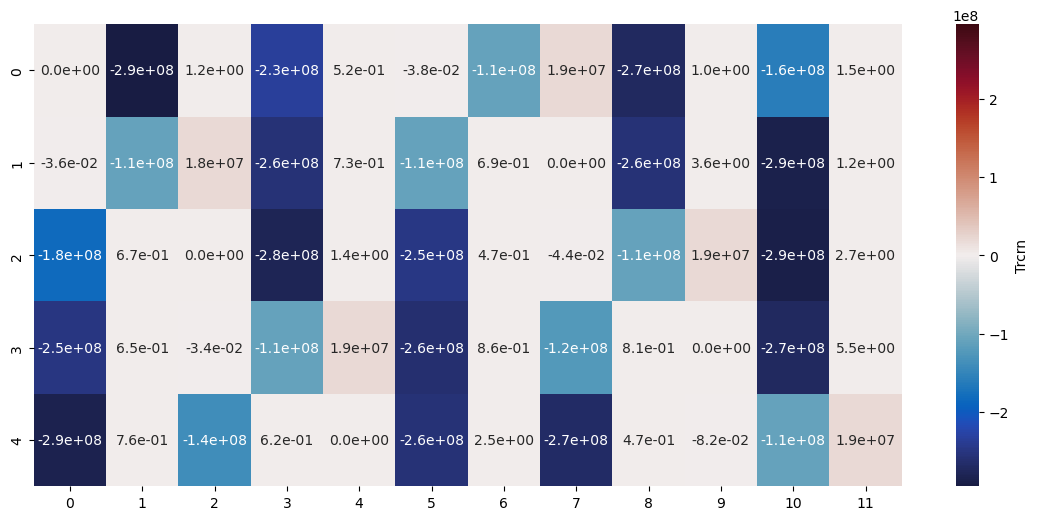

In [ ]:
absmax = np.abs(trcrn).max()
plt.figure(figsize=(14, 6))
sns.heatmap(
    trcrn.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    # center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'Trcrn'}
)

print("Miniumum Trcrn: ", trcrn.min())
print("Maximum Trcrn: ", trcrn.max())

Miniumum AFSDN:  -10960755.993883349
Maximum AFSDN:  137144.56196807986


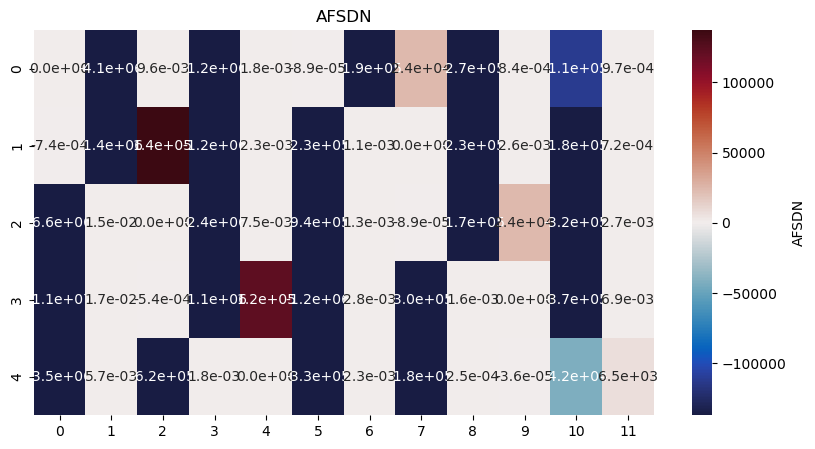

In [ ]:
def calculate_afsdn(trcrn, aicen):
    """
    Calculate the floe size distribution (FSD) for each ice thickness category.
    This function assumes that the tracer array `trcrn` is already populated.
    """
    nfsd = trcrn.shape[0] - nt_fsd  # Number of floe size categories
    ncat = trcrn.shape[1]            # Number of ice thickness categories

    afsdn = np.zeros((nfsd, ncat))  # Initialize FSD array

    for k in range(nfsd):
        for n in range(ncat):
            afsdn[k, n] = trcrn[nt_fsd + k, n] * aicen[n] / floe_rad_binwidths[k]

    # workd(i,j,k,n) = trcrn(i,j,nt_fsd+k-1,n,iblk) &
    #                        * aicen(i,j,n,iblk)/floe_binwidth(k)

    return afsdn
afsdn = calculate_afsdn(trcrn, aicen)

plt.figure(figsize=(10, 5))
absmax = np.abs(afsdn.max())
sns.heatmap(
    afsdn.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    # center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'AFSDN'}
)
plt.title('AFSDN')

print("Miniumum AFSDN: ", afsdn.min())
print("Maximum AFSDN: ", afsdn.max())

In [ ]:
# aicen_fit = aicen_fit * desired_aice

# aice = aicen_data.sum()  # Total ice concentration
# vice = vicen_data.sum()   # Total ice volume
# aicen = aicen_data # Ice area by category
# vicen = vicen_data

# afsdn_scaled = afsdn_pdf * aicen[np.newaxis, :]  # assuming aicen is an xarray DataArray, convert to numpy array

# Assign this scaled base to tracer array rows corresponding to nfsd
# trcrn = np.zeros((nt_fsd + nfsd, ncat))
# trcrn[nt_fsd:nt_fsd + nfsd, :] = base_scaled
# d_afsd_wave = np.zeros(nfsd)

# Call wave fracture routine (example)
d_afsd_wave_out, d_afsdn_wave_out, convergence_test = icepack_step_wavefracture(
    wave_spec_type="random",
    dt=dt,
    nfreq=nfreq,
    aice=aice,
    vice=vice,
    aicen=aicen,
    wave_spectrum=wave_spectrum,
    wavefreq=wavefreq,
    dwavefreq=dwavefreq,
    trcrn=trcrn,
    d_afsd_wave=d_afsd_wave,
    get_dafsd_wave=get_dafsd_wave,
    get_subdt_fsd=get_subdt_fsd,
    wave_frac=wave_frac,
    icepack_cleanup_fsd=icepack_cleanup_fsd,
    nfsd=nfsd,
    ncat=ncat,
    nt_fsd=nt_fsd
)

In [ ]:
print('Hs = ', np.round(4*np.sqrt(np.dot(dwavefreq, wave_spectrum)), 2), 'm')
print('Tp = ', np.round(1/wavefreq[wave_spectrum.argmax()], 2), 's')
print('aice = ', np.round(aicen.sum(), 2))
print('hi = ', np.round(vicen.sum(), 2), 'm')

Hs =  0.78 m
Tp =  11.14 s
aice =  0.73
hi =  1.27 m


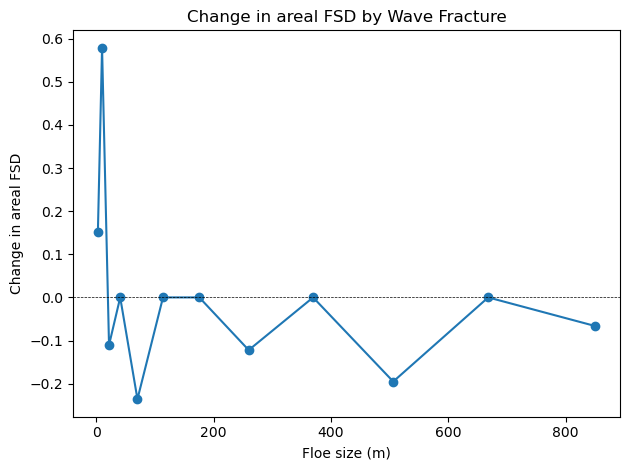

In [ ]:
plt.scatter(floe_rad_c, d_afsd_wave_out)
plt.plot(floe_rad_c, d_afsd_wave_out)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.xlabel('Floe size (m)')
plt.ylabel('Change in areal FSD')
plt.title('Change in areal FSD by Wave Fracture')
plt.tight_layout()
plt.show()

<Axes: >

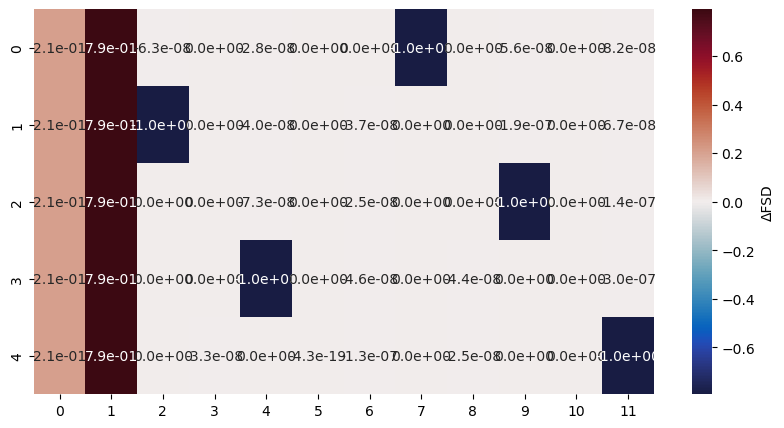

In [ ]:
absmax = np.abs(d_afsdn_wave_out.max())
plt.figure(figsize=(10, 5))
sns.heatmap(
    d_afsdn_wave_out.transpose(),
    annot=True,
    fmt=".1e",
    cmap=cmo.balance,
    center=0,
    vmin=-absmax,
    vmax=absmax,
    cbar_kws={'label': 'ΔFSD'}
)

In [ ]:
# plt.figure(figsize=(10, 5))
# sns.heatmap(
#     d_afsd_wave_data.transpose(),
#     annot=True,
#     fmt=".1e",
#     cmap=cmo.balance,
#     center=0,
#     vmin=-absmax,
#     vmax=absmax,
#     cbar_kws={'label': 'ΔFSD'}
# )


trcrn

array([[0.54992091, 0.54992091, 0.54992091, 0.54992091, 0.54992091],
       [0.45007909, 0.45007909, 0.45007909, 0.45007909, 0.45007909],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

### Searching for negative ice

In [385]:
from collections import deque
filename = '/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250717-131011'

n_before = 5
n_after = 5

counter = 0

with open(filename, 'r') as inF:
    prev_lines = deque(maxlen=n_before)  # stores previous n lines
    after_counter = 0

    for line in inF:
        if ' NEGATIVE ICE IN TRCRN!!!' in line:
            print("\n--- Match Found ---")
            for prev in prev_lines:
                print(prev.strip())
            print(line.strip())
            after_counter = n_after
            counter += 1
            if counter >= 50:
                print("\n--- Stopping after 1 matches ---")
                break
        elif after_counter > 0:
            print(line.strip())
            after_counter -= 1

        prev_lines.append(line)



--- Match Found ---
(step_dyn_wave)   vice  0.96419233983722430
(step_dyn_wave)   aicen  0.12447504382858646       0.82901518817526176        4.4106773581917412E-002   1.6748845399134624E-003   7.2810987432087417E-004
(step_dyn_wave)   wave_spectrum   0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000       (step_dyn_wave)   trcrn   0.0000000000000000       -21.706051262708435       -314119963.94009739       -302198267.69027609       -273227809.06277215       -133285873.99688837       -123273706.83548526        11.655945437509560  

### Lateral growth not converging

In [ ]:
from collections import deque
filename = '/Users/noahday/GitHub/cice-dev/cice-dirs/runs/test/cice.runlog.250716-140421'

n_before = 10
n_after = 2

counter = 0

with open(filename, 'r') as inF:
    prev_lines = deque(maxlen=n_before)  # stores previous n lines
    after_counter = 0  # how many lines after match to print

    for line in inF:
        if after_counter > 0:
            print(line.strip())
            after_counter -= 1

        if 'latg not converging' in line:
            print("\n--- Match Found ---")
            for prev in prev_lines:
                print(prev.strip())
            print(line.strip())
            after_counter = n_after
            counter += 1
            if counter > 0:  # stop after one matches
                print("\n--- Stopping after 1 matches ---")
                break

        prev_lines.append(line)
